In [5]:
wsi_labels_path = '/media/yanis/LaCie/Final_execution_files/test/labels_csv/labels.csv'
features_path = '/media/yanis/LaCie/Final_execution_files/test/features/'
labels_path = '/media/yanis/LaCie/Camelyon16/evaluation/reference.csv'
model_state_dict_path = './CLAM_fold_1.pt'

In [6]:
import os
import pandas as pd
from sklearn.utils import shuffle

def generate_balanced_test_set(directory_path, labels_csv_path):
    labels_df = pd.read_csv(labels_csv_path)

    filenames = [f for f in os.listdir(directory_path) if f.endswith('.pt')]
    
    slide_ids = ['_'.join(filename.split('_')[:2]) for filename in filenames]

    slide_ids_list = []
    labels_list = []

    for slide_id in slide_ids:
        matching_rows = labels_df[labels_df['image'].str.startswith(slide_id)]

        if not matching_rows.empty:
            label = matching_rows.iloc[0]['class']
            label = 'normal_tissue' if label == 'negative' else 'tumor_tissue'
            slide_ids_list.append(slide_id)
            labels_list.append(label)

    df = pd.DataFrame({'slide_id': slide_ids_list, 'label': labels_list})

    min_count = min(df['label'].value_counts())
    balanced_df = pd.concat([
        df[df['label'] == 'normal_tissue'].sample(min_count),
        df[df['label'] == 'tumor_tissue'].sample(min_count)
    ])

    balanced_df = shuffle(balanced_df)

    return balanced_df


directory_path = features_path 
labels_csv_path = labels_path  
csv_output_path = wsi_labels_path  


balanced_df = generate_balanced_test_set(directory_path, labels_csv_path)
balanced_df.to_csv(csv_output_path, index=False)


In [8]:
from torch.utils.data import Dataset
import pandas as pd
import torch

class WSI_dataset(Dataset):
    def __init__(self,wsi_list,features_path):
        self.wsi_list = wsi_list
        self.features_path = features_path
        self.label_to_int = {'normal_tissue': 0, 'tumor_tissue': 1}
    def __len__(self):
        return len(self.wsi_list)

    def __getitem__(self, idx):
        name = self.wsi_list[idx]['slide_id']
        label = torch.tensor(self.label_to_int[self.wsi_list[idx]['label']], dtype=torch.long)
        features = torch.load(self.features_path+name+'_features.pt')
        return (features,label)

100%|███████████████████████████████████████████| 36/36 [01:09<00:00,  1.92s/it]


test_loss: 0.7074, accuracy: 0.58, precision: 0.58, recall: 0.61, f1: 0.59, true_negatives: 10.00
Correctly classified : 21, Total : 36


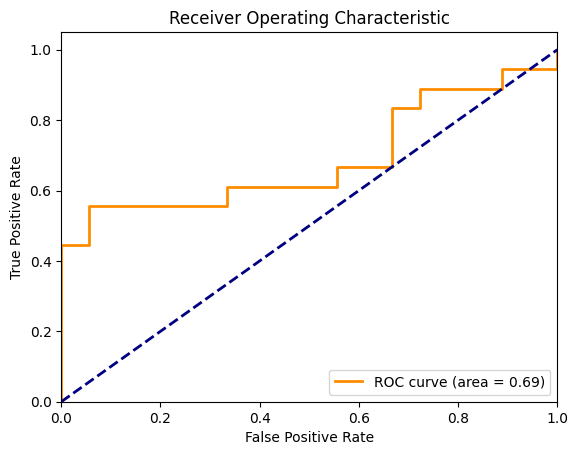

In [10]:
import pandas as pd
from torch.utils.data import DataLoader
from models.model_clam import CLAM_SB, CLAM_MB
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

wsi_df = pd.read_csv(wsi_labels_path)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_list = []

for _, row in wsi_df.iterrows():
    test_list.append(row)
        
test_dataset = WSI_dataset(test_list,features_path)
batch_size = 1
shuffle = True
num_workers = 4
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

loss_fn = nn.CrossEntropyLoss()
model_dict = {"dropout": True, 'n_classes': 2,"size_arg": 'small'}

model = CLAM_SB(**model_dict)
ckpt = torch.load(model_state_dict_path)
ckpt_clean = {}
for key in ckpt.keys():
    if 'instance_loss_fn' in key:
        continue
    ckpt_clean.update({key.replace('.module', ''):ckpt[key]})
model.load_state_dict(ckpt_clean, strict=True)

model.relocate() #met le modele sur le device (gpu)

model.eval()

total_acc = 0
false_pos = 0
true_pos = 0
true_neg = 0
false_neg = 0
test_loss = 0.0
all_preds_prob = []
all_labels = []
for index, (features, label) in enumerate(tqdm(test_loader)):
    #print('starting batch ',index)
    features = features.to(device)
    label = label.to(device)
    with torch.no_grad():
        logits, Y_prob, Y_hat, _, instance_dict = model(features, label=label, instance_eval=False)
        loss = loss_fn(logits, label)
        test_loss += loss.item()
        all_preds_prob.append(Y_prob[0][1].cpu())
        all_labels.append(label.cpu())
        pred = 0
        if(Y_prob[0][1]>0.49):
            pred=1
        else:
            pred=0
        if(pred == label):
            total_acc+=1
            if(pred==1):
                true_pos+=1
            else:
                true_neg+=1
        else:
            if(pred==1):
                false_pos+=1
            else:
                false_neg+=1

if(true_pos == 0):
    precision=0
    recall=0
    f1=0
else:
    precision = true_pos / (true_pos+false_pos)
    recall = true_pos / (true_pos+false_neg)
    f1 = (2*precision*recall)/(precision+recall)

total_acc /= len(test_loader)
test_loss /= len(test_loader)
print('test_loss: {:.4f}, accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}, f1: {:.2f}, true_negatives: {:.2f}'.format(test_loss, total_acc, precision, recall, f1, true_neg))
print('Correctly classified : {}, Total : {}'.format((true_pos+true_neg), len(test_loader)))

fpr, tpr, thresholds = roc_curve(all_labels, all_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()